In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pylab as plt
from tensorflow.keras.models import load_model
from keras.metrics import MeanSquaredError
from spacepy import pycdf
from spacepy.time import Ticktock
import os
from spacepy import pycdf
from spacepy.time import Ticktock

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']	
plt.rcParams['axes.unicode_minus'] = False

d:\anaconda3\envs\tensorflow\lib\site-packages\spacepy\time.py:2341: UserWarning: Leapseconds may be out of date. Use spacepy.toolbox.update(leapsecs=True)
  warnings.warn('Leapseconds may be out of date.'


In [2]:
model = load_model('LSTM_55_model.h5', custom_objects={'mse': MeanSquaredError()})



In [3]:


def process_cdf_file(file_path):
    with pycdf.CDF(file_path) as cdf:
        if 'PA_Midpoint' not in cdf:
            print(f"在文件 {file_path} 中未找到 'FPDU_ENERGY_LABL' 变量，跳过该文件。")
            return pd.DataFrame()  # 返回空的 DataFrame
        # 读取时间变量，并将其转换为 datetime 对象
        epoch = cdf['Epoch'][...]
        tt = Ticktock(epoch, 'CDFepoch')
        datetime_array = np.array(tt.UTC)

        # 读取能量标签
        FPDU_ENERGY_LABL = cdf['FPDU_Energy'][...]  # 形状：[能量]
        #将FPDU_ENERGY_LABL保留三位小数
        FPDU_ENERGY_LABL = np.round(FPDU_ENERGY_LABL, 3)
        FPDU_ENERGY_LABL = np.array(FPDU_ENERGY_LABL).astype(str)  # 转换为字符串数组
        FPDU_ENERGY_LABL = FPDU_ENERGY_LABL.squeeze()
        # 去除前后空格并转换为大写
        FPDU_ENERGY_LABL_clean = np.char.strip(FPDU_ENERGY_LABL)
        FPDU_ENERGY_LABL_upper = np.char.upper(FPDU_ENERGY_LABL_clean)
        

        # 查找包含 'LOW/2' 的能量标签（不区分大小写）
        # target_label = '114'############################################################################################################################################################################
        # contains_target = np.char.find(FPDU_ENERGY_LABL_upper, target_label.upper()) >= 0
        # energy_indices = np.where(contains_target)[0]
        # print(energy_indices)

        target_labels = ['0.269']
        for target_label in target_labels:
            contains_target = np.char.find(FPDU_ENERGY_LABL_upper, target_label.upper()) >= 0
            energy_indices = np.where(contains_target)[0]
            if len(energy_indices) > 0:
                energy_kev=0.269
                break

        if len(energy_indices) == 0:
            print(f"在文件 {file_path} 中未找到包含 '{target_label}' 的能量标签")
            return pd.DataFrame()  # 返回空的 DataFrame 
        else:
            energy_index = energy_indices[0]  # 获取第一个匹配的索引

        # 读取通量数据和相关变量
        FPDU_corr = cdf['FPDU_OmniFlux'][...]  # 形状：[时间，俯仰角，能量]
        I = cdf['I'][...]
        L = cdf['L'][...]
        Position = cdf['Position'][...]
        MLT = cdf['MLT'][...]
        FPDU_ERROR = cdf['FPDU_Error'][...]

    # 获取数据的维度
    

    # 提取并展开数据，以匹配总记录数
    time_array = datetime_array
    flux_array = FPDU_corr[:, energy_index]
 
   
    I_array = I
    L_array = L
   
    MLT_array = MLT
    # MLAT_array = MLAT[time_flat]
    Position_array = Position
    X_array = Position_array[:, 0]
    Y_array = Position_array[:, 1]
    Z_array = Position_array[:, 2]
    Error = FPDU_ERROR[:, energy_index,1:5].sum(axis=1)

    data = {
        'Time': time_array,
        'Flux': flux_array,
        
        'I': I_array,
        'L': L_array,
       
        # 'L_star_PitchAngle': L_star_PitchAngle_array,
        'MLT': MLT_array,
        'X': X_array,
        'Y': Y_array,
        'Z': Z_array,
        'Flux_Error': Error,
        'energy_kev': energy_kev,
    }

    
    # 创建 DataFrame
    df = pd.DataFrame(data)
    df = df[df['L'] >= 2]
    df = df[df['Flux'] >0]
    if df.shape[0] == 0:
        print(f"在文件 {file_path} 中未找到有效数据")
        return pd.DataFrame()
    
    return df






In [4]:
folder_paths = [ '../RB']  # 请替换为您的文件夹路径
# 存储所有 CDF 文件的路径
cdf_files = []

# 遍历所有文件夹，获取其中的 CDF 文件
for folder_path in folder_paths:
    cdf_files.extend([os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.cdf')])
print(len(cdf_files))
df_list = []
youxiao=0
wuxiao=0
cdf_files=cdf_files[1700:2200]
for file_path in cdf_files:
    print(f"Processing file: {file_path}")
    df = process_cdf_file(file_path)
    if not df.empty:
        df_list.append(df)
        youxiao+=1
    else:
        wuxiao+=1
        print(f"跳过文件 {file_path}，因为不包含目标能量标签。")
if df_list:
    combined_df = pd.concat(df_list, ignore_index=True)
    # 可选：查看拼接后的 DataFrame 的前几行
    print(combined_df.head())
else:
    print("未找到包含目标能量标签的数据。")
print(youxiao)
print(wuxiao)

2098
Processing file: ../RB\rbsp-b-rbspice_lev-3-pap_tofxeh_20171019_v1.2.4-01.cdf
Processing file: ../RB\rbsp-b-rbspice_lev-3-pap_tofxeh_20171020_v1.2.4-01.cdf
Processing file: ../RB\rbsp-b-rbspice_lev-3-pap_tofxeh_20171021_v1.2.4-01.cdf
Processing file: ../RB\rbsp-b-rbspice_lev-3-pap_tofxeh_20171022_v1.2.4-01.cdf
Processing file: ../RB\rbsp-b-rbspice_lev-3-pap_tofxeh_20171023_v1.2.4-01.cdf
Processing file: ../RB\rbsp-b-rbspice_lev-3-pap_tofxeh_20171024_v1.2.4-01.cdf
Processing file: ../RB\rbsp-b-rbspice_lev-3-pap_tofxeh_20171025_v1.2.4-01.cdf
Processing file: ../RB\rbsp-b-rbspice_lev-3-pap_tofxeh_20171026_v1.2.4-01.cdf
Processing file: ../RB\rbsp-b-rbspice_lev-3-pap_tofxeh_20171027_v1.2.4-01.cdf
Processing file: ../RB\rbsp-b-rbspice_lev-3-pap_tofxeh_20171029_v1.2.4-01.cdf
Processing file: ../RB\rbsp-b-rbspice_lev-3-pap_tofxeh_20171030_v1.2.4-01.cdf
Processing file: ../RB\rbsp-b-rbspice_lev-3-pap_tofxeh_20171031_v1.2.4-01.cdf
Processing file: ../RB\rbsp-b-rbspice_lev-3-pap_tofxeh_2017

In [5]:
start_time = '2018-01-01 00:00:00'
end_time = '2019-01-01 00:00:00'
# start_time = '2016-10-28 00:00:00'
# end_time = '2016-11-25 00:00:00'

mask = (combined_df['Time'] >= start_time) & (combined_df['Time'] <= end_time)
combined_df = combined_df.loc[mask]
#按顺序从df中每11个数据取一个
combined_df=combined_df.iloc[::10,:]

In [6]:
print(combined_df)

                           Time          Flux    I         L        MLT  \
329994  2018-01-01 00:17:52.348  9.898734e+04  3.0  3.880290   5.267984   
330004  2018-01-01 00:19:39.783  1.813542e+07  3.0  3.922991   5.314185   
330014  2018-01-01 00:21:27.218  2.164145e+07  3.0  3.965079   5.359447   
330024  2018-01-01 00:23:14.650  2.146282e+07  3.0  4.006561   5.403811   
330034  2018-01-01 00:25:02.086  2.098786e+07  3.0  4.047447   5.447320   
...                         ...           ...  ...       ...        ...   
2608594 2018-12-27 23:52:39.508  2.220191e+06  1.0  5.380836  16.979265   
2608604 2018-12-27 23:54:25.907  1.992580e+06  1.0  5.411201  17.006657   
2608614 2018-12-27 23:56:12.308  1.841898e+06  1.0  5.441061  17.033792   
2608624 2018-12-27 23:57:58.713  1.579987e+06  1.0  5.470417  17.060678   
2608634 2018-12-27 23:59:45.116  1.618174e+06  1.0  5.499272  17.087307   

                X         Y         Z  Flux_Error  energy_kev  
329994   0.717663  3.757859  0.6402

In [7]:
combined_df = combined_df.sort_values('Time')
combined_df = combined_df.reset_index(drop=True)

In [8]:
TQ=pd.read_csv('../空间天气参数/TQ.txt',sep='\s+',header=None)
TQ.columns=['year','day','hour','BXGSM','BYGSM','BZGSM','TEMP','DEN','PDYN','Kp','Dst','F107','AE','AL','AU']
TQ['datetime'] = pd.to_datetime(TQ['year'].astype(str) + TQ['day'].astype(str).str.zfill(3) + TQ['hour'].astype(str).str.zfill(2), format='%Y%j%H')
TQ=TQ.drop(['year','day','hour'],axis=1)
TQ = TQ.sort_values(by='datetime')
TQ.set_index('datetime', inplace=True)
#去除TQ['TQ']中的异常值

#删除TQ中的BXGSM列
TQ=TQ.drop(['BXGSM'],axis=1)
TQ=TQ.drop(['BYGSM'],axis=1)
TQ=TQ.drop(['DEN'],axis=1)

print(TQ)

                     BZGSM     TEMP  PDYN  Kp  Dst  F107    AE     AL     AU
datetime                                                                    
2010-01-01 00:00:00    1.6  36035.0  0.51   0    5  72.7     4     -2      2
2010-01-01 01:00:00    1.6  30846.0  0.52   0    4  72.7     4     -2      1
2010-01-01 02:00:00    1.2  27445.0  0.52   0    4  72.7     4     -2      2
2010-01-01 03:00:00    1.0  25799.0  0.60   0    2  72.7     3     -2      2
2010-01-01 04:00:00    0.3  25220.0  0.52   0    0  72.7     3     -1      2
...                    ...      ...   ...  ..  ...   ...   ...    ...    ...
2020-01-01 19:00:00   -0.3  18136.0  2.30  10    2  69.4  9999  99999  99999
2020-01-01 20:00:00   -0.2  16553.0  2.31  10    5  69.4  9999  99999  99999
2020-01-01 21:00:00    0.4  17917.0  2.37   7    7  69.4  9999  99999  99999
2020-01-01 22:00:00    1.2  18613.0  2.14   7    6  69.4  9999  99999  99999
2020-01-01 23:00:00    1.1  19557.0  1.89   7    5  69.4  9999  99999  99999

In [9]:
from scipy import stats

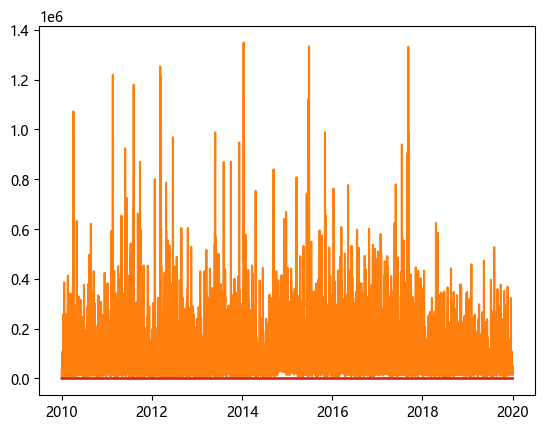

In [10]:
# z_scores = np.abs(stats.zscore(TQ['BXGSM']))
# threshold = 3  # 设置Z-score阈值
# TQ['BXGSM_IS1'] = np.where(z_scores >= threshold, 0, 1)
# TQ['BXGSM_no_outliers'] = TQ['BXGSM'].where(z_scores < threshold, np.nan)  # 将异常值替换为NaN

# # 在原位置插值
# TQ['BXGSM'] = TQ['BXGSM_no_outliers'].interpolate(method='time')
# # 删除临时列
# TQ = TQ.drop(columns=['BXGSM_no_outliers'])
# plt.plot(TQ.index, TQ['BXGSM'])

# z_scores = np.abs(stats.zscore(TQ['BYGSM']))
# threshold = 3  # 设置Z-score阈值
# TQ['BYGSM_IS1'] = np.where(z_scores >= threshold, 0, 1)
# TQ['BYGSM_no_outliers'] = TQ['BYGSM'].where(z_scores < threshold, np.nan)  # 将异常值替换为NaN

# # 在原位置插值
# TQ['BYGSM'] = TQ['BYGSM_no_outliers'].interpolate(method='time')
# # 删除临时列
# TQ = TQ.drop(columns=['BYGSM_no_outliers'])
# plt.plot(TQ.index, TQ['BYGSM'])

z_scores = np.abs(stats.zscore(TQ['BZGSM']))
threshold = 3  # 设置Z-score阈值
TQ['BZGSM_IS1'] = np.where(z_scores >= threshold, 0, 1)
TQ['BZGSM_no_outliers'] = TQ['BZGSM'].where(z_scores < threshold, np.nan)  # 将异常值替换为NaN

# 在原位置插值
TQ['BZGSM'] = TQ['BZGSM_no_outliers'].interpolate(method='time')
# 删除临时列
TQ = TQ.drop(columns=['BZGSM_no_outliers'])
plt.plot(TQ.index, TQ['BZGSM'])

z_scores = np.abs(stats.zscore(TQ['TEMP']))
threshold = 3  # 设置Z-score阈值
TQ['TEMP_IS1'] = np.where(z_scores >= threshold, 0, 1)
TQ['TEMP_no_outliers'] = TQ['TEMP'].where(z_scores < threshold, np.nan)  # 将异常值替换为NaN

# 在原位置插值
TQ['TEMP'] = TQ['TEMP_no_outliers'].interpolate(method='time')
# 删除临时列
TQ = TQ.drop(columns=['TEMP_no_outliers'])
plt.plot(TQ.index, TQ['TEMP'])

# z_scores = np.abs(stats.zscore(TQ['DEN']))
# threshold = 3  # 设置Z-score阈值
# TQ['DEN_IS1'] = np.where(z_scores >= threshold, 0, 1)  # 标记异常值
# TQ['DEN_no_outliers'] = TQ['DEN'].where(z_scores < threshold, np.nan)  # 将异常值替换为NaN

# # 在原位置插值
# TQ['DEN'] = TQ['DEN_no_outliers'].interpolate(method='time')
# # 删除临时列
# TQ = TQ.drop(columns=['DEN_no_outliers'])
# plt.plot(TQ.index, TQ['DEN'])

z_scores = np.abs(stats.zscore(TQ['PDYN']))
threshold = 3  # 设置Z-score阈值
TQ['PDYN_IS1'] = np.where(z_scores >= threshold, 0, 1)
TQ['PDYN_no_outliers'] = TQ['PDYN'].where(z_scores < threshold, np.nan)  # 将异常值替换为NaN

# 在原位置插值
TQ['PDYN'] = TQ['PDYN_no_outliers'].interpolate(method='time')
# 删除临时列
TQ = TQ.drop(columns=['PDYN_no_outliers'])
plt.plot(TQ.index, TQ['PDYN'])

z_scores = np.abs(stats.zscore(TQ['F107']))
threshold = 3  # 设置Z-score阈值
TQ['F107_IS1'] = np.where(z_scores >= threshold, 0, 1)
TQ['F107_no_outliers'] = TQ['F107'].where(z_scores < threshold, np.nan)  # 将异常值替换为NaN

# 在原位置插值
TQ['F107'] = TQ['F107_no_outliers'].interpolate(method='time')
# 删除临时列
TQ = TQ.drop(columns=['F107_no_outliers'])
plt.plot(TQ.index, TQ['F107'])

                        VX  SYMH
datetime                        
2012-01-01 00:00:00 -367.4   -11
2012-01-01 00:05:00 -367.4   -10
2012-01-01 00:10:00 -368.7    -9
2012-01-01 00:15:00 -368.8    -8
2012-01-01 00:20:00 -370.4    -7
...                    ...   ...
2020-01-01 23:35:00 -305.7     4
2020-01-01 23:40:00 -306.6     4
2020-01-01 23:45:00 -306.9     4
2020-01-01 23:50:00 -307.4     5
2020-01-01 23:55:00 -309.0     3

[841824 rows x 2 columns]


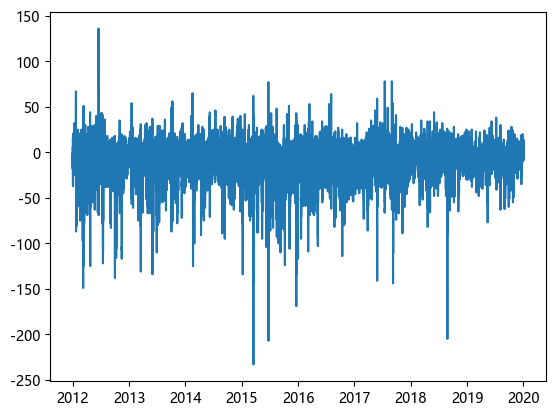

In [11]:
V_H_5=pd.read_csv('../空间天气参数/V_H_5.txt',sep='\s+',header=None)
V_H_5.columns=['year','day','hour','min','VX', 'VY', 'VZ', 'SYMH']
year_str = V_H_5['year'].astype(str)
day_str = V_H_5['day'].astype(str).str.zfill(3)
hour_str = V_H_5['hour'].astype(str).str.zfill(2)
min_str = V_H_5['min'].astype(str).str.zfill(2)

# 合并字符串
datetime_str = year_str + day_str + hour_str + min_str

# 转换为 datetime 对象
V_H_5['datetime'] = pd.to_datetime(datetime_str, format='%Y%j%H%M')
V_H_5=V_H_5.drop(['year','day','hour','min'],axis=1)
V_H_5 = V_H_5.sort_values(by='datetime')
V_H_5.set_index('datetime', inplace=True)

V_H_5=V_H_5.drop(['VY'],axis=1)
V_H_5=V_H_5.drop(['VZ'],axis=1)
print(V_H_5)



z_scores = np.abs(stats.zscore(V_H_5['VX']))
threshold = 3  # 设置Z-score阈值
V_H_5['VX_IS1'] = np.where(z_scores >= threshold, 0, 1)
V_H_5['VX_no_outliers'] = V_H_5['VX'].where(z_scores < threshold, np.nan)  # 将异常值替换为NaN
# 在原位置插值
V_H_5['VX'] = V_H_5['VX_no_outliers'].interpolate(method='time')
# 删除临时列
V_H_5 = V_H_5.drop(columns=['VX_no_outliers'])

# z_scores = np.abs(stats.zscore(V_H_5['VY']))
# threshold = 3  # 设置Z-score阈值
# V_H_5['VY_IS1'] = np.where(z_scores >= threshold, 0, 1)
# V_H_5['VY_no_outliers'] = V_H_5['VY'].where(z_scores < threshold, np.nan)  # 将异常值替换为NaN
# # 在原位置插值
# V_H_5['VY'] = V_H_5['VY_no_outliers'].interpolate(method='time')
# # 删除临时列
# V_H_5 = V_H_5.drop(columns=['VY_no_outliers'])

# z_scores = np.abs(stats.zscore(V_H_5['VZ']))
# threshold = 3  # 设置Z-score阈值
# V_H_5['VZ_IS1'] = np.where(z_scores >= threshold, 0, 1)
# V_H_5['VZ_no_outliers'] = V_H_5['VZ'].where(z_scores < threshold, np.nan)  # 将异常值替换为NaN
# # 在原位置插值
# V_H_5['VZ'] = V_H_5['VZ_no_outliers'].interpolate(method='time')
# # 删除临时列
# V_H_5 = V_H_5.drop(columns=['VZ_no_outliers'])

# z_scores = np.abs(stats.zscore(V_H_5['SYMH']))
# threshold = 3  # 设置Z-score阈值
# V_H_5['SYMH_no_outliers'] = V_H_5['SYMH'].where(z_scores < threshold, np.nan)  # 将异常值替换为NaN
# # 在原位置插值
# V_H_5['SYMH'] = V_H_5['SYMH_no_outliers'].interpolate(method='time')
# # 删除临时列
# V_H_5 = V_H_5.drop(columns=['SYMH_no_outliers'])

plt.plot(V_H_5.index, V_H_5['SYMH'])

V_H_5=V_H_5.resample('1H').mean()

combined_df['Time'] = pd.to_datetime(combined_df['Time'])

combined_df = combined_df.sort_values('Time')

combined_df = combined_df.reset_index(drop=True)



In [12]:
TQ = TQ.reset_index()
print(TQ)


                 datetime  BZGSM     TEMP  PDYN  Kp  Dst  F107    AE     AL  \
0     2010-01-01 00:00:00    1.6  36035.0  0.51   0    5  72.7     4     -2   
1     2010-01-01 01:00:00    1.6  30846.0  0.52   0    4  72.7     4     -2   
2     2010-01-01 02:00:00    1.2  27445.0  0.52   0    4  72.7     4     -2   
3     2010-01-01 03:00:00    1.0  25799.0  0.60   0    2  72.7     3     -2   
4     2010-01-01 04:00:00    0.3  25220.0  0.52   0    0  72.7     3     -1   
...                   ...    ...      ...   ...  ..  ...   ...   ...    ...   
87667 2020-01-01 19:00:00   -0.3  18136.0  2.30  10    2  69.4  9999  99999   
87668 2020-01-01 20:00:00   -0.2  16553.0  2.31  10    5  69.4  9999  99999   
87669 2020-01-01 21:00:00    0.4  17917.0  2.37   7    7  69.4  9999  99999   
87670 2020-01-01 22:00:00    1.2  18613.0  2.14   7    6  69.4  9999  99999   
87671 2020-01-01 23:00:00    1.1  19557.0  1.89   7    5  69.4  9999  99999   

          AU  BZGSM_IS1  TEMP_IS1  PDYN_IS1  F107_I

In [13]:
V_H_5 = V_H_5.reset_index()
print(V_H_5)

                 datetime          VX       SYMH    VX_IS1
0     2012-01-01 00:00:00 -374.658333  -7.083333  1.000000
1     2012-01-01 01:00:00 -381.091667  -2.666667  1.000000
2     2012-01-01 02:00:00 -380.633333  -6.416667  1.000000
3     2012-01-01 03:00:00 -371.725000  -8.500000  1.000000
4     2012-01-01 04:00:00 -370.633333 -11.833333  1.000000
...                   ...         ...        ...       ...
70147 2020-01-01 19:00:00 -327.700000  -1.333333  1.000000
70148 2020-01-01 20:00:00 -326.316667   4.000000  1.000000
70149 2020-01-01 21:00:00 -321.150000   6.500000  0.666667
70150 2020-01-01 22:00:00 -310.816667   5.583333  0.583333
70151 2020-01-01 23:00:00 -307.491667   4.750000  0.833333

[70152 rows x 4 columns]


In [14]:
combined_df['datetime_hour'] = combined_df['Time'].dt.floor('H')

# 保存原始列名（确保每次循环从原始列开始）
original_TQ_columns = TQ.columns.tolist()
original_V_H_5_columns = V_H_5.columns.tolist()

for i in range(1, 121):
    combined_df[f'datetime_minus_h'] = combined_df['datetime_hour'] - pd.Timedelta(hours=i)
    
    # 每次循环使用原始列名创建临时副本（避免污染原始数据）
    temp_TQ = TQ.rename(columns={col: f"{col}_{i}h" for col in original_TQ_columns if col != 'datetime'})
    temp_V_H_5 = V_H_5.rename(columns={col: f"{col}_{i}h" for col in original_V_H_5_columns if col != 'datetime'})
    
    # 合并临时副本
    combined_df = combined_df.merge(
        temp_TQ,
        left_on=f'datetime_minus_h',
        right_on='datetime',
        how='left'
    ).drop(columns=['datetime'])
    
    combined_df = combined_df.merge(
        temp_V_H_5,
        left_on=f'datetime_minus_h',
        right_on='datetime',
        how='left'
    ).drop(columns=['datetime'])
    print(f"已添加 {i} 小时前的数据")


已添加 1 小时前的数据
已添加 2 小时前的数据
已添加 3 小时前的数据
已添加 4 小时前的数据
已添加 5 小时前的数据
已添加 6 小时前的数据
已添加 7 小时前的数据
已添加 8 小时前的数据
已添加 9 小时前的数据
已添加 10 小时前的数据
已添加 11 小时前的数据
已添加 12 小时前的数据
已添加 13 小时前的数据
已添加 14 小时前的数据
已添加 15 小时前的数据
已添加 16 小时前的数据
已添加 17 小时前的数据
已添加 18 小时前的数据
已添加 19 小时前的数据
已添加 20 小时前的数据
已添加 21 小时前的数据
已添加 22 小时前的数据
已添加 23 小时前的数据
已添加 24 小时前的数据
已添加 25 小时前的数据
已添加 26 小时前的数据
已添加 27 小时前的数据
已添加 28 小时前的数据
已添加 29 小时前的数据
已添加 30 小时前的数据
已添加 31 小时前的数据
已添加 32 小时前的数据
已添加 33 小时前的数据
已添加 34 小时前的数据
已添加 35 小时前的数据
已添加 36 小时前的数据
已添加 37 小时前的数据
已添加 38 小时前的数据
已添加 39 小时前的数据
已添加 40 小时前的数据
已添加 41 小时前的数据
已添加 42 小时前的数据
已添加 43 小时前的数据
已添加 44 小时前的数据
已添加 45 小时前的数据
已添加 46 小时前的数据
已添加 47 小时前的数据
已添加 48 小时前的数据
已添加 49 小时前的数据
已添加 50 小时前的数据
已添加 51 小时前的数据
已添加 52 小时前的数据
已添加 53 小时前的数据
已添加 54 小时前的数据
已添加 55 小时前的数据
已添加 56 小时前的数据
已添加 57 小时前的数据
已添加 58 小时前的数据
已添加 59 小时前的数据
已添加 60 小时前的数据
已添加 61 小时前的数据
已添加 62 小时前的数据
已添加 63 小时前的数据
已添加 64 小时前的数据
已添加 65 小时前的数据
已添加 66 小时前的数据
已添加 67 小时前的数据
已添加 68 小时前的数据
已添加 69 小时前的数据
已添加 70 小时前的数据
已添加 71 小时前的数据
已添加 72 小时前的数据
已

In [15]:
# dfdf=combined_df.iloc[::10, :]

dfdf=combined_df

In [16]:
# #找到2014-04-12 00:00:00到2014-04-13 00:00:00之间的数据
# start_time = '2013-03-16 12:00:00'
# end_time = '2013-03-19 00:00:00'

# mask = (combined_df['Time'] >= start_time) & (combined_df['Time'] <= end_time)
# dfdf = combined_df.loc[mask]
# #按顺序从df中每11个数据取一个
# dfdf = dfdf.iloc[::11, :]


# print(dfdf)

In [17]:
#dfdf重新排序
dfdf = dfdf.reset_index(drop=True)

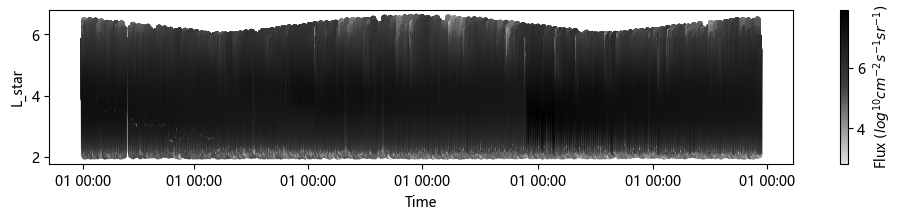

In [18]:
#以数据的L_star为纵坐标，Time为横坐标，Flux为颜色
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib.dates as mdates
cmap1 = LinearSegmentedColormap.from_list("custom1", ["#dee2e6", "#404040", "#000000"]) 

plt.figure(figsize=(12, 2))
plt.scatter(dfdf['Time'], dfdf['L'], c=np.log10(dfdf['Flux']), cmap=cmap1, s=10)
plt.colorbar(label='Flux ${(log^{10} cm^{-2}s^{-1}sr^{-1})}$')
plt.xlabel('Time')
plt.ylabel('L_star')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M'))
plt.show()


In [19]:
time_steps=120
VX_time1 = [f'VX_{i}h' for i in range(1, time_steps + 1)]
SYMH_time2 = [f'SYMH_{i}h' for i in range(1, time_steps + 1)]
VX_IS1_time3 = [f'VX_IS1_{i}h' for i in range(1, time_steps + 1)]
BZGSM_time4 = [f'BZGSM_{i}h' for i in range(1, time_steps + 1)]
TEMP_time5 = [f'TEMP_{i}h' for i in range(1, time_steps + 1)]
PDYN_time6 = [f'PDYN_{i}h' for i in range(1, time_steps + 1)]
Kp_time7 = [f'Kp_{i}h' for i in range(1, time_steps + 1)]
Dst_time8 = [f'Dst_{i}h' for i in range(1, time_steps + 1)]
F107_time9 = [f'F107_{i}h' for i in range(1, time_steps + 1)]
AE_time10 = [f'AE_{i}h' for i in range(1, time_steps + 1)]
AL_time11 = [f'AL_{i}h' for i in range(1, time_steps + 1)]
AU_time12 = [f'AU_{i}h' for i in range(1, time_steps + 1)]
BZGSM_IS1_time13 = [f'BZGSM_IS1_{i}h' for i in range(1, time_steps + 1)]
TEMP_IS1_time14 = [f'TEMP_IS1_{i}h' for i in range(1, time_steps + 1)]
PDYN_IS1_time15 = [f'PDYN_IS1_{i}h' for i in range(1, time_steps + 1)]
F107_IS1_time16 = [f'F107_IS1_{i}h' for i in range(1, time_steps + 1)]

In [ ]:
X_time1 = combined_df[VX_time1].values  
X_time2 = combined_df[SYMH_time2].values 
X_time3 = combined_df[VX_IS1_time3].values
X_time4 = combined_df[BZGSM_time4].values
X_time5 = combined_df[TEMP_time5].values
X_time6 = combined_df[PDYN_time6].values
X_time7 = combined_df[Kp_time7].values
X_time8 = combined_df[Dst_time8].values
X_time9 = combined_df[F107_time9].values
X_time10 = combined_df[AE_time10].values
X_time11 = combined_df[AL_time11].values
X_time12 = combined_df[AU_time12].values
X_time13 = combined_df[BZGSM_IS1_time13].values
X_time14 = combined_df[TEMP_IS1_time14].values
X_time15 = combined_df[PDYN_IS1_time15].values
X_time16 = combined_df[F107_IS1_time16].values


X_time = np.stack((X_time1, X_time2,X_time3,X_time4,X_time5,X_time6,X_time7,X_time8,X_time9,X_time10,X_time11,X_time12,X_time13,X_time14,X_time15,X_time16), axis=2)
print(X_time.shape)
# 定义非时间序列特征列
non_time_features = [ 'I', 'MLT',  'L']

# 提取非时间序列数据
X_non_time = combined_df[non_time_features].values  # 形状 (num_samples, 3)
y=np.log10(combined_df['Flux'].values) # 形状 (num_samples,)

# 如果是二分类任务，将其转换为二维数组
y = y.reshape(-1, 1)  # 形状 (num_samples, 1)

(227865, 120, 16)


In [21]:
import joblib
scaler_time = joblib.load('scaler_time.pkl')
scaler_non_time = joblib.load('scaler_non_time.pkl')
scaler_target = joblib.load('scaler_target.pkl')
num_samples = X_time.shape[0]
time_steps = 120  # 根据您的数据调整
num_features = 16
X_time_reshaped = X_time.reshape(-1, num_features)
X_time_scaled = scaler_time.transform(X_time_reshaped)
X_time = X_time_scaled.reshape(num_samples, time_steps, num_features)
X_non_time = scaler_non_time.transform(X_non_time)
y = scaler_target.transform(y)

7121/7121 [==============================] - 20s 3ms/step


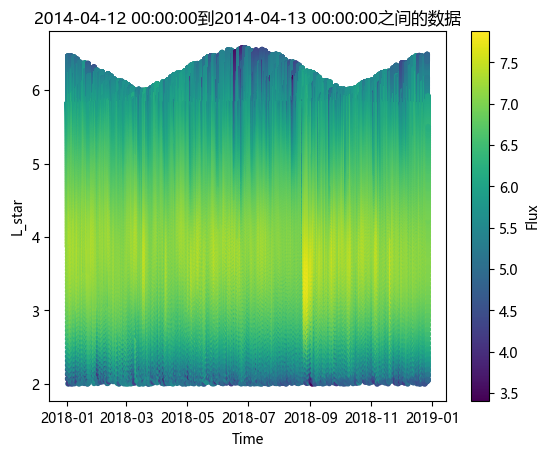

In [22]:
y_pred11 = model.predict([X_time, X_non_time])
y_pred11 = scaler_target.inverse_transform(y_pred11)

y_pred11 = 10**(y_pred11)


plt.scatter(dfdf['Time'], dfdf['L'], c=np.log10(y_pred11), cmap='viridis', s=10)
plt.colorbar(label='Flux')
plt.xlabel('Time')
plt.ylabel('L_star')
plt.title('2014-04-12 00:00:00到2014-04-13 00:00:00之间的数据')
plt.show()

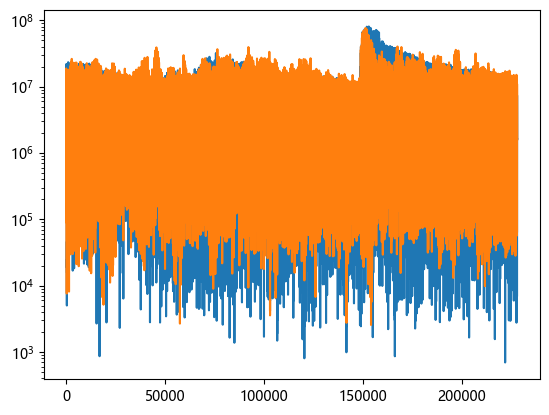

In [23]:
plt.plot(dfdf['Flux'])
plt.plot(y_pred11)
plt.yscale('log')


In [24]:
from sklearn.metrics import r2_score

# 真实值
y_true = dfdf['Flux'].values

# 预测值
y_pred = y_pred11

# 计算 R²
r2 = r2_score(y_true, y_pred)

print(f'R²值: {r2}')

R²值: 0.7936696419757765


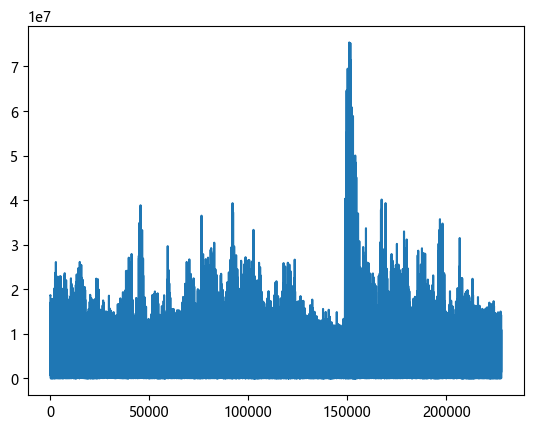

In [25]:
plt.plot(y_pred11)

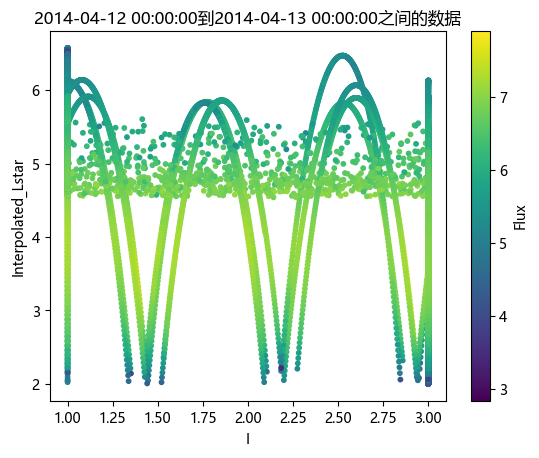

In [26]:
#画dfdf['B_Calc']的和dfdf['L_start']的散点图
plt.scatter(dfdf['I'], dfdf['L'], c=np.log10(dfdf['Flux']), cmap='viridis', s=10)
plt.colorbar(label='Flux')
plt.xlabel('I')
plt.ylabel('Interpolated_Lstar')
plt.title('2014-04-12 00:00:00到2014-04-13 00:00:00之间的数据')
plt.show()

In [27]:
Dst=pd.read_csv('../空间天气参数/Dst.txt',sep='\s+',header=None)
Dst.columns=['year','day','hour','Dst']
Dst['datetime'] = pd.to_datetime(Dst['year'].astype(str) + Dst['day'].astype(str).str.zfill(3) + Dst['hour'].astype(str).str.zfill(2), format='%Y%j%H')
Dst=Dst.drop(['year','day','hour'],axis=1)
Dst = Dst.sort_values(by='datetime')

In [28]:
mask = (Dst['datetime'] >= start_time) & (Dst['datetime'] <= end_time)
Dst = Dst.loc[mask]


In [29]:
print(Dst)

        Dst            datetime
333120   -5 2018-01-01 00:00:00
333121   -7 2018-01-01 01:00:00
333122  -13 2018-01-01 02:00:00
333123  -10 2018-01-01 03:00:00
333124  -13 2018-01-01 04:00:00
...     ...                 ...
341876   -5 2018-12-31 20:00:00
341877   -5 2018-12-31 21:00:00
341878   -3 2018-12-31 22:00:00
341879   -2 2018-12-31 23:00:00
341880   -3 2019-01-01 00:00:00

[8761 rows x 2 columns]


(227865,)


C:\Users\root\AppData\Local\Temp\ipykernel_28340\991751476.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to leave space for colorbar


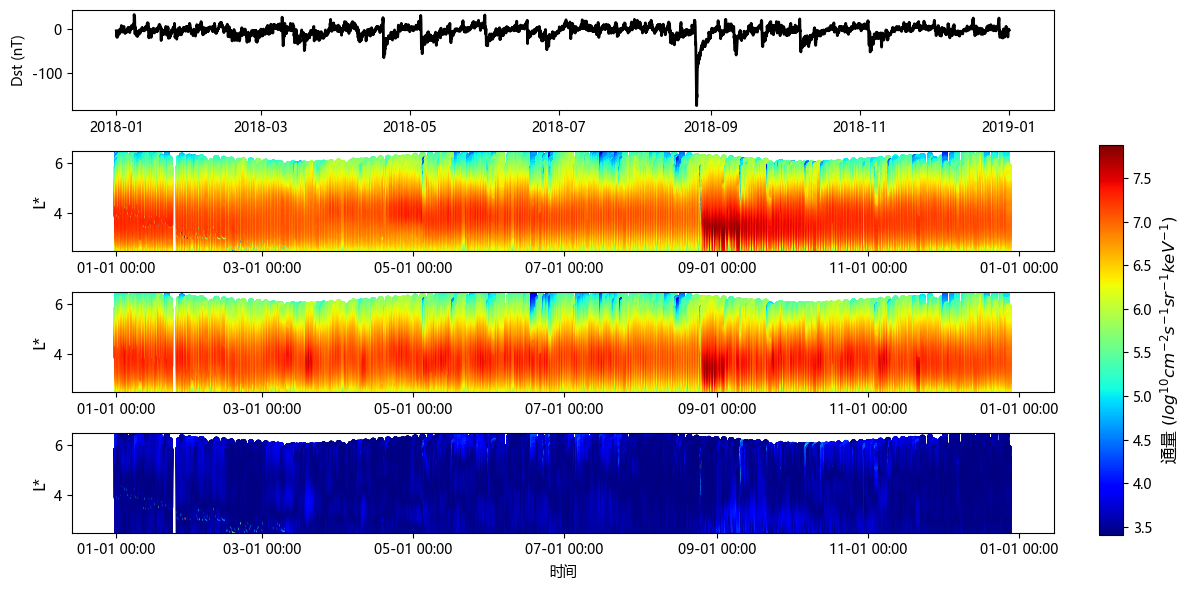

In [30]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates
import numpy as np

# Define custom colormap
cmap1 = LinearSegmentedColormap.from_list("custom1", ["#f8f9fa", "#e9ecef", "#000000"])
max=np.log10(y_pred11).max()
min=np.log10(y_pred11).min()
cmap1 = 'jet'
# Create (3, 1) subplot layout without shared axes
fig, axes = plt.subplots(4, 1, figsize=(12, 6))

# Plot each subplot
time_nums = mdates.date2num(dfdf['Time'])

axes[0].plot(Dst['datetime'], Dst['Dst'], linestyle='-', c='black', linewidth=2)
axes[0].set_ylabel('Dst (nT)')



sc = axes[1].scatter(dfdf['Time'], dfdf['L'], c=np.log10(dfdf['Flux']), cmap=cmap1, s=10, vmin=min, vmax=max)
axes[1].set_ylabel('L*', fontsize=12)
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
axes[1].set_ylim(2.5,6.5)

axes[2].scatter(dfdf['Time'], dfdf['L'], c=np.log10(y_pred11), cmap=cmap1, s=10, vmin=min, vmax=max)
axes[2].set_ylabel('L*', fontsize=12)
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
axes[2].set_ylim(2.5,6.5)

# print(np.log10(y_pred11).shape)
# print(np.log10(dfdf['Flux']+1699/5 ).shape)

ccc=abs(np.log10(y_pred11).reshape(-1)-np.log10(dfdf['Flux']))
print(ccc.shape)


axes[3].scatter(dfdf['Time'], dfdf['L'], c=ccc, cmap=cmap1, s=10)
axes[3].set_ylabel('L*', fontsize=12)
axes[3].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
axes[3].set_ylim(2.5,6.5)

axes[-1].set_xlabel('时间')

# Add shared colorbar (place it further to the right)
cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.65])  # [left, bottom, width, height]
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label('通量 ${(log^{10} cm^{-2}s^{-1}sr^{-1}keV^{-1})}$' , fontsize=12)

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to leave space for colorbar
plt.show()


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns




# 计算均方根误差（RMSE）
rmse = np.sqrt(mean_squared_error(np.log10(y_pred11), np.log10(dfdf['Flux'])))
#r2 = r2_score(np.log10(y_pred11), np.log10(dfdf['Flux']))
r2 = r2_score( np.log10(dfdf['Flux']),np.log10(y_pred11))
print(f'测试集上的 RMSE: {rmse}',f'测试集上的 R2: {r2}')

测试集上的 RMSE: 0.20478128017729655 测试集上的 R2: 0.9013447842463139


In [32]:
#保存dfdf['Flux'] 和 y_pred11的数据为txt文件
np.savetxt('y_test_exp_269_2017_B.txt',dfdf['Flux'])
np.savetxt('y_pred_exp_269_2017_B.txt',y_pred11)


In [33]:
print(dfdf)

                          Time          Flux    I         L        MLT  \
0      2018-01-01 00:17:52.348  9.898734e+04  3.0  3.880290   5.267984   
1      2018-01-01 00:19:39.783  1.813542e+07  3.0  3.922991   5.314185   
2      2018-01-01 00:21:27.218  2.164145e+07  3.0  3.965079   5.359447   
3      2018-01-01 00:23:14.650  2.146282e+07  3.0  4.006561   5.403811   
4      2018-01-01 00:25:02.086  2.098786e+07  3.0  4.047447   5.447320   
...                        ...           ...  ...       ...        ...   
227860 2018-12-27 23:52:39.508  2.220191e+06  1.0  5.380836  16.979265   
227861 2018-12-27 23:54:25.907  1.992580e+06  1.0  5.411201  17.006657   
227862 2018-12-27 23:56:12.308  1.841898e+06  1.0  5.441061  17.033792   
227863 2018-12-27 23:57:58.713  1.579987e+06  1.0  5.470417  17.060678   
227864 2018-12-27 23:59:45.116  1.618174e+06  1.0  5.499272  17.087307   

               X         Y         Z  Flux_Error  energy_kev  ... AE_120h  \
0       0.717663  3.757859  0.6402

In [34]:
dfdf_huatu=dfdf[['Time','L','Flux']]
dfdf_huatu.to_csv('dfdf_269_2017_B.csv',index=False)
